## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

Площадь под кривой precision-recall: 0.12354743460693855


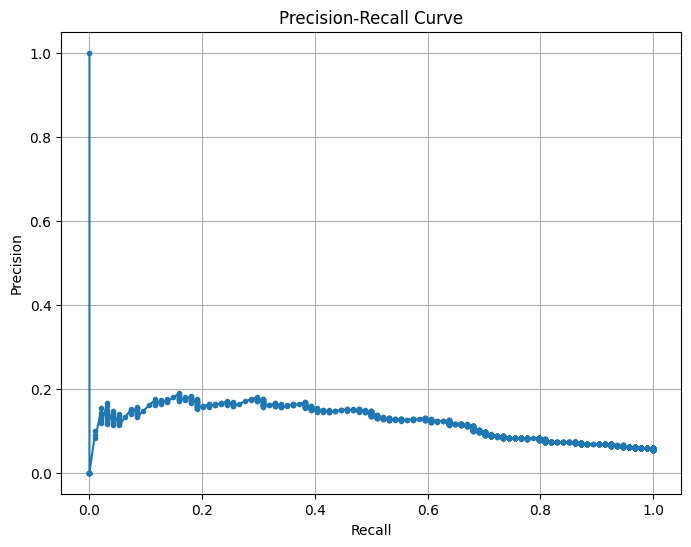

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Загрузка данных
data = pd.read_csv('application_train.csv')

# 2. Предобработка данных
# Удаление строк с пропусками (можно использовать другие методы обработки)
data = data.dropna()

# Преобразование категориальных переменных в числовые
data = pd.get_dummies(data, drop_first=True)

# 3. Определение признаков и целевой переменной
X = data.drop('TARGET', axis=1) 
y = data['TARGET']

# 4. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. Обучение модели
model = LogisticRegression(max_iter=1000, solver='liblinear')  # Увеличиваем max_iter и меняем solver
model.fit(X_train, y_train)

# 7. Оценка модели
y_scores = model.predict_proba(X_test)[:, 1]  # Вероятности положительного класса
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

# Вывод результатов
print(f'Площадь под кривой precision-recall: {pr_auc}')

# Визуализация кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import time
import re

# 1. Загрузка данных
data = pd.read_csv('application_train.csv')  # Замените на путь к вашему набору данных

# 2. Предобработка данных
# Удаление строк с пропусками (можно использовать другие методы обработки)
data = data.dropna()

# Преобразование категориальных переменных в числовые
data = pd.get_dummies(data, drop_first=True)

# 3. Переименование признаков для устранения специальных символов
data.columns = [col.replace(' ', '_').replace('#', '').replace('@', '').replace('!', '') for col in data.columns]
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #фиксим вылезающую ошибку про неправильный нейминг признаков https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
# 4. Определение признаков и целевой переменной
X = data.drop('TARGET', axis=1)  # Замените 'TARGET' на имя вашей целевой переменной
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Обучение модели LightGBM
start_time = time.time()
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_fit_time = time.time() - start_time

# 7. Обучение модели CatBoost
start_time = time.time()
cat_model = CatBoostClassifier(silent=True)  # Убираем вывод логов
cat_model.fit(X_train, y_train)
cat_fit_time = time.time() - start_time

# 8. Оценка качества моделей
lgb_predictions = lgb_model.predict(X_test)
cat_predictions = cat_model.predict(X_test)

lgb_accuracy = accuracy_score(y_test, lgb_predictions)
cat_accuracy = accuracy_score(y_test, cat_predictions)

# 9. Вывод результатов
print(f'LightGBM Accuracy: {lgb_accuracy:.4f}, Fit Time: {lgb_fit_time:.4f} seconds')
print(f'CatBoost Accuracy: {cat_accuracy:.4f}, Fit Time: {cat_fit_time:.4f} seconds')

[LightGBM] [Info] Number of positive: 432, number of negative: 6449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10566
[LightGBM] [Info] Number of data points in the train set: 6881, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062782 -> initscore=-2.703255
[LightGBM] [Info] Start training from score -2.703255
LightGBM Accuracy: 0.9431, Fit Time: 0.4187 seconds
CatBoost Accuracy: 0.9454, Fit Time: 10.0530 seconds


При незначительном преимуществе в точности меньше процента время затраченное увеличено в 25 раз

__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# 1. Загрузка данных
data = pd.read_csv('application_train.csv')  # Замените на путь к вашему набору данных
data = data.dropna()  # Предобработка данных

# 2. Определение признаков и целевой переменной
X = data.drop('TARGET', axis=1)  # Замените 'TARGET' на имя вашей целевой переменной
y = data['TARGET']

# 3. Преобразование категориальных признаков
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Преобразование в строку для кодирования
    label_encoders[col] = le

# 4. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Подбор параметров для LightGBM
lgb_model = lgb.LGBMClassifier()

lgb_param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

lgb_grid_search = GridSearchCV(lgb_model, lgb_param_grid, cv=3, scoring='accuracy')
lgb_grid_search.fit(X_train, y_train)

print("Best parameters for LightGBM:", lgb_grid_search.best_params_)
cat_model = CatBoostClassifier(silent=True)

cat_param_grid = {
    'depth': [3, 5, 7, 9],
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

cat_grid_search = GridSearchCV(cat_model, cat_param_grid, cv=3, scoring='accuracy')
cat_grid_search.fit(X_train, y_train)

print("Best parameters for CatBoost:", cat_grid_search.best_params_)

[LightGBM] [Info] Number of positive: 288, number of negative: 4299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10306
[LightGBM] [Info] Number of data points in the train set: 4587, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062786 -> initscore=-2.703177
[LightGBM] [Info] Start training from score -2.703177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
# Пример загрузки данных
data = pd.read_csv('application_traincsv')
# Определите категориальные столбцы
categorical_cols = ['category_col1', 'category_col2']  

# Инициализация OHE
ohe = OneHotEncoder(sparse=False)

# Применение OHE
encoded_features = ohe.fit_transform(data[categorical_cols])

# Создание DataFrame с новыми признаками
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_cols))

# Объединение с оригинальным DataFrame и удаление исходных категориальных столбцов
data = pd.concat([data.drop(categorical_cols, axis=1), encoded_df], axis=1)

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ